# Fitting of a single Gaussian on a peptide during refolding

One peptide (residue 24-42, one charged state) is extracted from DynamX (identified using PLGS) and at each refolding timepoint a single gaussian curve is fitted over the isotope distribution to define the unfolded and folded distribution (mainly used for the FD and Native controls)

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
import numpy as np
from symfit import Variable, Parameter, parameters, Fit, exp, pi, sqrt
from symfit.distributions import Gaussian
from symfit.core.models import CallableModel

from functools import reduce
from operator import add

In [3]:
df = pd.read_excel("peptide 24_42_4Cfolding_ppiA.xlsx", skiprows=[0, 1], header=[0])
df = df.dropna(how='any')

#Making a library with indexes
series_dict = {}
for i, col in enumerate(df):
    if i % 2 == 0:
        idx = df.iloc[:, i]
        data = df.iloc[:, i + 1]
        data.index = idx
        data /= np.trapz(data, data.index)

        series_dict[data.name] = data

Text(0.5, 0, 'm/z')

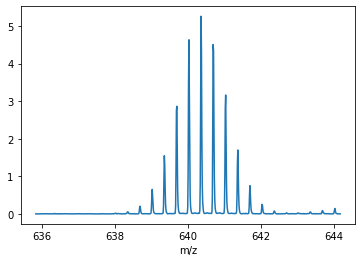

In [5]:
#Selection of the fully deuterated control to fit gaussian
s = series_dict['fd_1']
fig, ax = plt.subplots()
ax.plot(s.index, s)
ax.set_xlabel('m/z')


Text(0.5, 0, 'm/z')

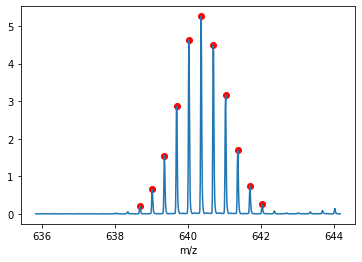

In [8]:
# Selection of peaks with the tops indicated
idx = find_peaks(s, prominence=0.2)[0]

xp = s.index.to_numpy()[idx]
yp = s.to_numpy()[idx]

fig, ax = plt.subplots()
ax.plot(s.index, s)
ax.scatter(xp, yp, color='r')
ax.set_xlabel('m/z')

In [9]:
#The peak with highest intensity is selected as the average
x_max = xp[np.argmax(yp)]
x_max

640.367

In [10]:
#The width of the gaussian 
diffs = np.diff(xp).mean()
x_sig = 2*diffs

a = np.max(yp)

In [11]:
# Description and fitting of gaussian curve to data
x_var = Variable('x')
y_var = Variable('y')
a_par, mu_par, sig_par = parameters('a mu sigma')
a_par.value = a
a_par.min = 0
mu_par.value = x_max
sig_par.value = x_sig

model = CallableModel({y_var: a_par*(exp(-(x_var - mu_par)**2/(2*sig_par**2)))})

fit = Fit(model, x=xp, y=yp)
fit_result = fit.execute()
print(fit_result)

Scalar Parameters:
Parameter | Value       | Standard Deviation
a           5.194806e+00  None
mu          6.403863e+02  None
sigma       6.571092e-01  None
Status message         b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
Number of iterations   10
Objective              <symfit.core.objectives.LeastSquares object at 0x0000026929C330F0>
Minimizer              <symfit.core.minimizers.LBFGSB object at 0x0000026929C33E48>

Goodness of fit qualifiers:
chi_squared            0.07225181502323198
objective_value        0.03612590751161599
r_squared              0.9979213253307355


In [12]:
# Plotting the fit on a figure with good resolution (with x 100 steps)
x_vec = np.linspace(s.index.min(), s.index.max(), num=100, endpoint=True)
y_vec = model(x=x_vec, **fit_result.params)

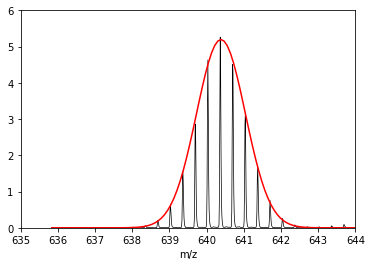

In [13]:
fig, ax = plt.subplots()
ax.plot(s.index, s, color ='k', linewidth=0.7)
#ax.scatter(xp, yp, color='r')
ax.plot(x_vec, y_vec[0],color='r')
ax.set_ylim(0,6)
ax.set_xlim(635,644)
ax.set_xlabel('m/z')
plt.savefig('4C_FD.png')
